# Import Dataset

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

In [2]:
data = fetch_openml(name="boston", version=1, as_frame=True)
boston = data.frame
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Matrix Korelasi "Spearman"

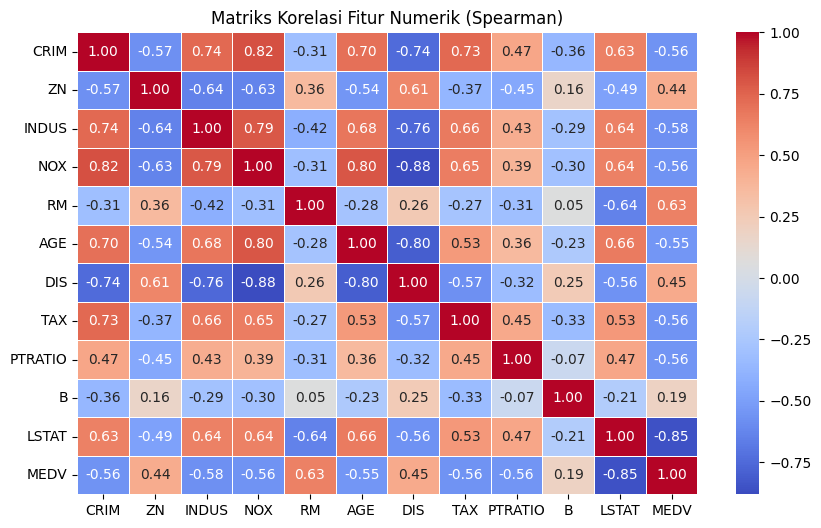

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_method = "spearman"

plt.figure(figsize=(10, 6))
sns.heatmap(boston.select_dtypes(include=["number"]).corr(method=correlation_method),
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Matriks Korelasi Fitur Numerik ({correlation_method.capitalize()})")
plt.show()

## Select Features

In [9]:
data = boston[['LSTAT','PTRATIO', 'TAX', 'AGE', 'RM', 'NOX', 'INDUS', 'CRIM','MEDV']]
data.head()

,LSTAT,PTRATIO,TAX,AGE,RM,NOX,INDUS,CRIM,MEDV
0,4.98,15.3,296.0,65.2,6.575,0.538,2.31,0.00632,24.0
1,9.14,17.8,242.0,78.9,6.421,0.469,7.07,0.02731,21.6
2,4.03,17.8,242.0,61.1,7.185,0.469,7.07,0.02729,34.7
3,2.94,18.7,222.0,45.8,6.998,0.458,2.18,0.03237,33.4
4,5.33,18.7,222.0,54.2,7.147,0.458,2.18,0.06905,36.2


## Splitting

In [10]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="MEDV")
y = data["MEDV"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 8), (102, 8), (404,), (102,))

## Training

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('yeo', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), list(X_train.columns))
    ]
)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

parameter = {
    'algo__C': [0.1, 1, 10, 100],
    'algo__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'algo__degree': [2, 3, 4],
    'algo__gamma': ['scale', 'auto'],
    'algo__coef0': [0.0, 0.5, 1.0],
    'algo__max_iter': [2000, 5000, 10000]
}

In [39]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomizedSearchCV(pipeline, param_distributions=parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_iter': 2000, 'algo__kernel': 'poly', 'algo__gamma': 'scale', 'algo__degree': 4, 'algo__coef0': 1.0, 'algo__C': 1}
0.9210733876724024 0.8618867825474225 0.8451946720196301


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## Evaluasi Model

In [45]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Train R² Score: {r2_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train MAPE: {mape_train:.2f}%\n")

print("**Evaluasi pada Data Test**")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%")

Jumlah data train: 404
Jumlah data test: 102

**Evaluasi pada Data Train**
Train R² Score: 0.9211
Train MAE: 1.6218
Train MSE: 6.8566
Train RMSE: 2.6185
Train MAPE: 8.38%

**Evaluasi pada Data Test**
Test R² Score: 0.8452
Test MAE: 2.0115
Test MSE: 11.3525
Test RMSE: 3.3693
Test MAPE: 10.32%


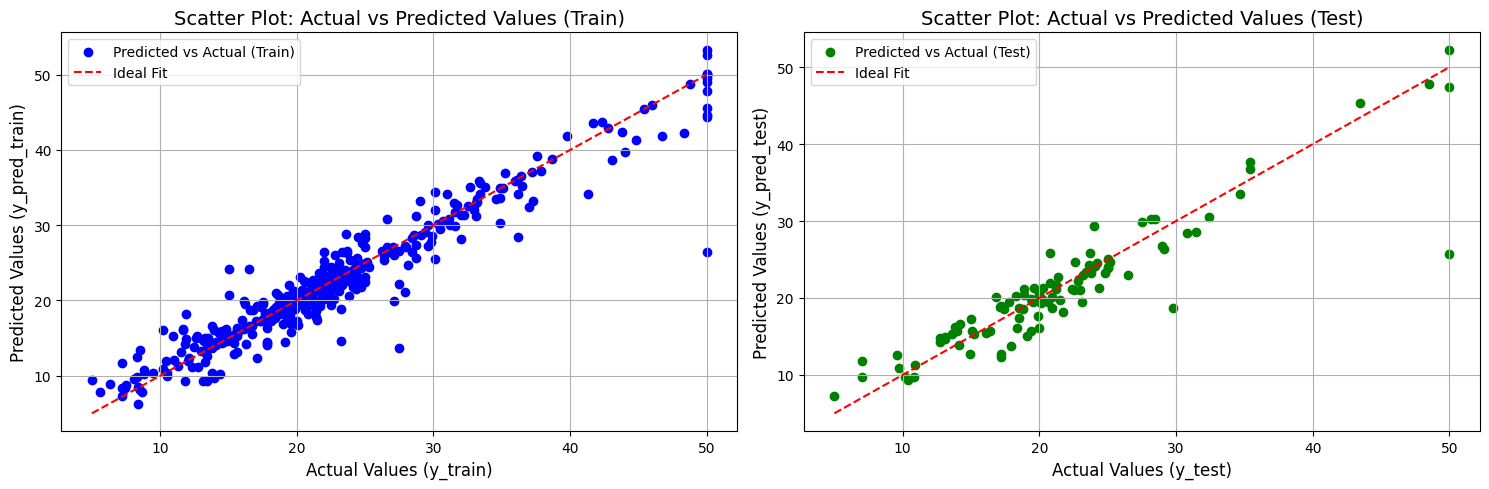

In [52]:
import matplotlib.pyplot as plt

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_train, y_pred_train, color='blue', label='Predicted vs Actual (Train)')
axes[0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Ideal Fit')
axes[0].set_title('Scatter Plot: Actual vs Predicted Values (Train)', fontsize=14)
axes[0].set_xlabel('Actual Values (y_train)', fontsize=12)
axes[0].set_ylabel('Predicted Values (y_pred_train)', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(y_test, y_pred_test, color='green', label='Predicted vs Actual (Test)')
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
axes[1].set_title('Scatter Plot: Actual vs Predicted Values (Test)', fontsize=14)
axes[1].set_xlabel('Actual Values (y_test)', fontsize=12)
axes[1].set_ylabel('Predicted Values (y_pred_test)', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

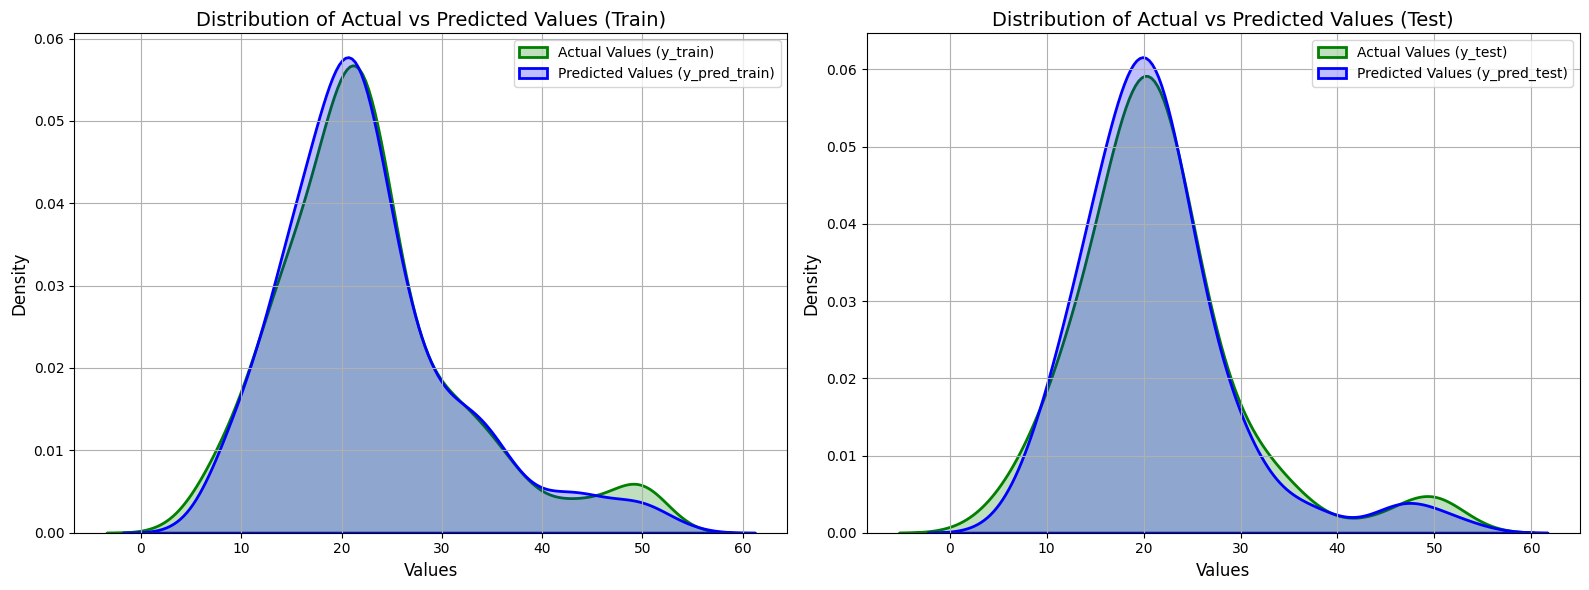

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(y_train, color='green', label='Actual Values (y_train)', fill=True, linewidth=2, ax=axes[0])
sns.kdeplot(y_pred_train, color='blue', label='Predicted Values (y_pred_train)', fill=True, linewidth=2, ax=axes[0])

axes[0].set_title('Distribution of Actual vs Predicted Values (Train)', fontsize=14)
axes[0].set_xlabel('Values', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend()
axes[0].grid(True)

sns.kdeplot(y_test, color='green', label='Actual Values (y_test)', fill=True, linewidth=2, ax=axes[1])
sns.kdeplot(y_pred_test, color='blue', label='Predicted Values (y_pred_test)', fill=True, linewidth=2, ax=axes[1])

axes[1].set_title('Distribution of Actual vs Predicted Values (Test)', fontsize=14)
axes[1].set_xlabel('Values', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

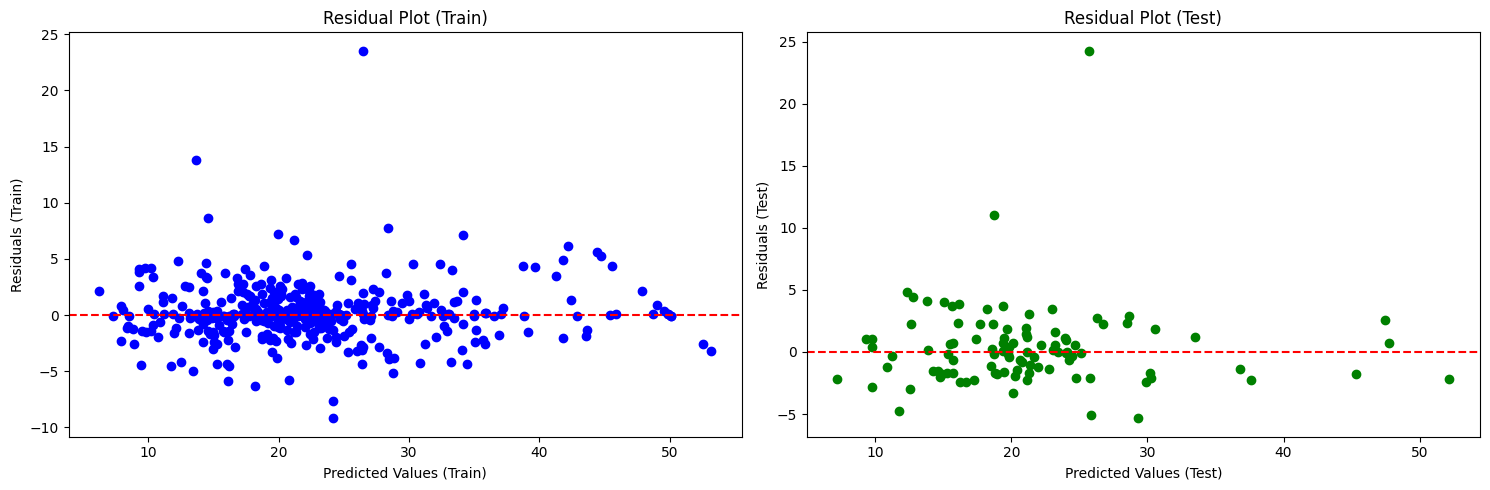

In [66]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values (Train)")
plt.ylabel("Residuals (Train)")
plt.title("Residual Plot (Train)")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals_test, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values (Test)")
plt.ylabel("Residuals (Test)")
plt.title("Residual Plot (Test)")

plt.tight_layout()
plt.show()

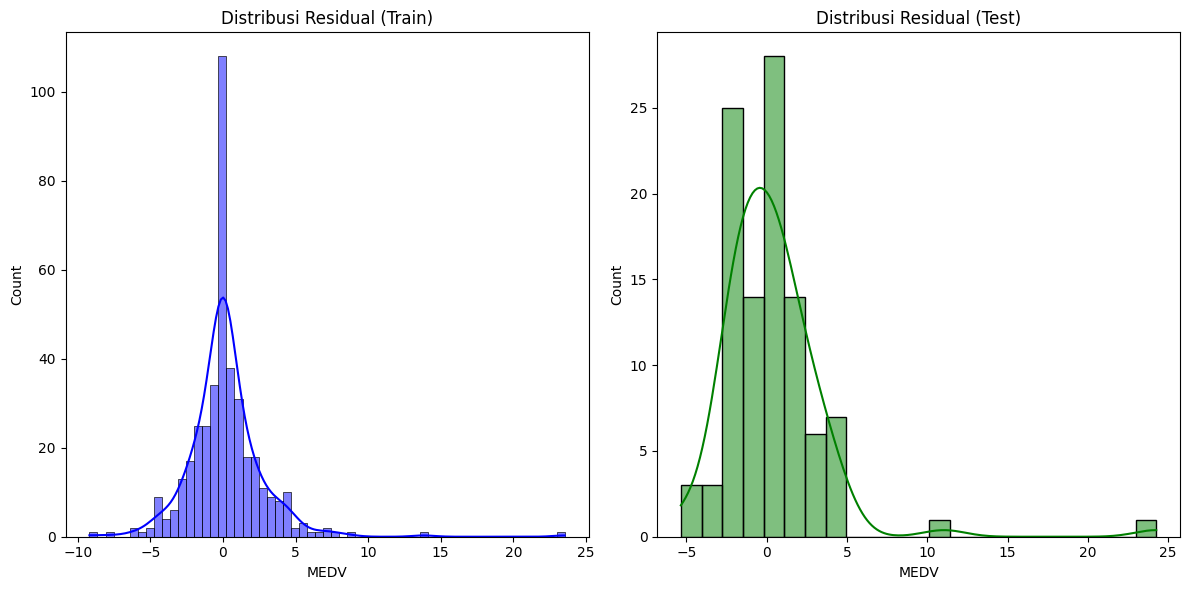

In [69]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals_train, kde=True, color='blue')
plt.title("Distribusi Residual (Train)")

plt.subplot(1, 2, 2)
sns.histplot(residuals_test, kde=True, color='green')
plt.title("Distribusi Residual (Test)")

plt.tight_layout()
plt.show()

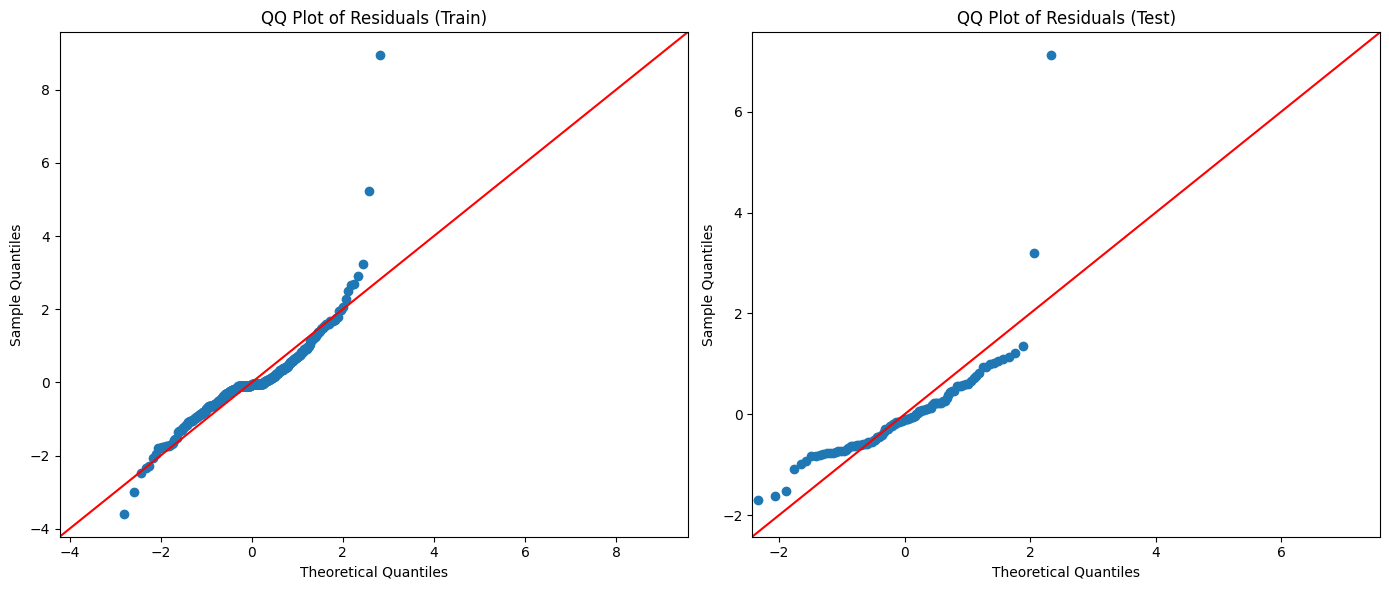

In [70]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sm.qqplot(residuals_train, line='45', fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals (Train)")

plt.subplot(1, 2, 2)
sm.qqplot(residuals_test, line='45', fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals (Test)")

plt.tight_layout()
plt.show()

## Save Model

In [ ]:
import pickle

best_pipeline = model.best_estimator_
with open("model.pkl", "wb") as file:
    pickle.dump(best_pipeline, file)

## Load Model

In [ ]:
import pickle

with open("model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

## Prediksi Data Baru

In [71]:
X_train.iloc[0]

,477
LSTAT,24.9100
PTRATIO,20.2000
TAX,666.0000
AGE,97.3000
RM,5.3040
NOX,0.6140
INDUS,18.1000
CRIM,15.0234


In [83]:
new_data = {
    'LSTAT': [12.5, 24.1, 15.8],
    'PTRATIO': [17.8, 20.2, 18.5],
    'TAX': [320.0, 666.0, 345.0],
    'AGE': [85.0, 97.3, 90.5],
    'RM': [6.7, 5.3, 7.0],
    'NOX': [0.5, 0.614, 0.45],
    'INDUS': [10.2, 18.1, 12.4],
    'CRIM': [1.35, 15.0234, 0.78]
}

X_new = pd.DataFrame(new_data)

X_new['MEDV_Predict'] = loaded_model.predict(X_new)
X_new

,LSTAT,PTRATIO,TAX,AGE,RM,NOX,INDUS,CRIM,MEDV_Predict
0,12.5,17.8,320.0,85.0,6.7,0.500,10.2,1.3500,23.287297
1,24.1,20.2,666.0,97.3,5.3,0.614,18.1,15.0234,12.189020
2,15.8,18.5,345.0,90.5,7.0,0.450,12.4,0.7800,22.929378
